In [1]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.cm as colormap
import time

import re
import os
import os.path
import glob
from PIL import Image
from skimage import io

from sklearn.model_selection import StratifiedKFold                              
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from keras.utils import np_utils

from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
from vis.utils import utils
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from vis.visualization import visualize_cam,visualize_saliency,overlay
from keras import activations

# Disable GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyPortex"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in image.list_pictures(list_fams[i], ext='jpg|jpeg|bmp|png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [5]:
# Creating base model (VGG16 convolutional layers)
image_shape = (224, 224, 3)                                                                                                                                               
weights='weights-portex-xception-Adam-100epochs-fromscratch.h5'
model = Xception(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.load_weights(weights)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [7]:
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'predictions')

# https://github.com/raghakot/keras-vis/issues/53
# "You need to specify penultimate_layer_idx in this case.
# By default, it will use the AveragePooling layer which does not have any spatial resolution.
# Try using the layer above it which has a (7, 7) resolution."
penultimate_layer_idx = utils.find_layer_idx(model, 'block14_sepconv2_act')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

Family: allaple
Image: ['79b763792e6263b6ecf178d77c9b7ba44dd04d9927b945631c769b5a0f303862.png'] - Class: ['allaple'] - Pred: 0 (allaple) - Prob: 27.97
Image: ['c29efc762cb7f96ddfdd597cc8ea102a505b4a330aeabaa9042a3cc0b1350496.png'] - Class: ['allaple'] - Pred: 0 (allaple) - Prob: 30.26
Image: ['78bbe4f97ec6d573123aa6f8e566cbd3b29ac96a4e9a7478d75e9b4a8b7716f2.png'] - Class: ['allaple'] - Pred: 0 (allaple) - Prob: 26.93
Image: ['1e495afb2452a3d54cdf657993b38be546f29dd1e2e4cd24c83b9c9d47ff2a74.png'] - Class: ['allaple'] - Pred: 0 (allaple) - Prob: 29.35
Image: ['482626b06302a0483d4d2f68938733d683e184c4c9f942445396e19b63228449.png'] - Class: ['allaple'] - Pred: 0 (allaple) - Prob: 31.80
Image: ['f386b78b81955c13a8f669fd5768f05de2368a8f627fb6ade9a55b399072b769.png'] - Class: ['allaple'] - Pred: 0 (allaple) - Prob: 37.21
Image: ['f1d3af87c5e7899189e3ea6d7fc21774eb05fdb871f3984d4d172cb42440beb4.png'] - Class: ['allaple'] - Pred: 0 (allaple) - Prob: 29.07
Image: ['483eb2f64d8cdaf653131c63aa3b0d

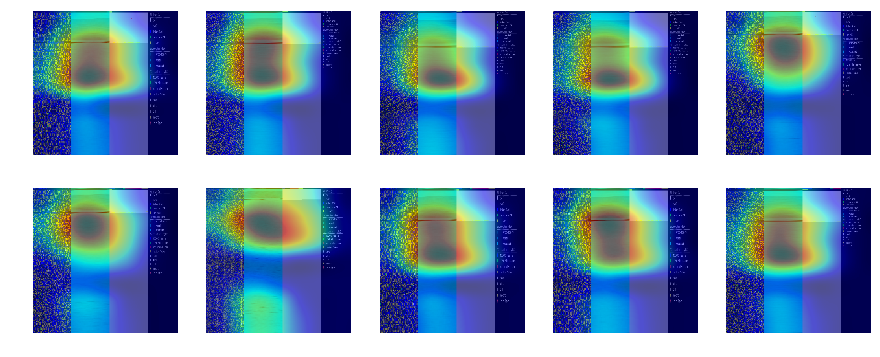

Family: alman
Image: ['84808d6febb2273d14a270e4d5fa0a50db82d75d72050b131f529d33934ff96c.png'] - Class: ['alman'] - Pred: 1 (alman) - Prob: 21.54
Image: ['0dd3a1b5adcb6f9750e44a8472c4c9ede507efc2017970423c1d7d7cd8c96cfc.png'] - Class: ['alman'] - Pred: 1 (alman) - Prob: 17.31
Image: ['8dbae80a3570c0bd50cea5b49fc7569f620a88fc7e9b1c8ff3ecb9d8dfaf1337.png'] - Class: ['alman'] - Pred: 1 (alman) - Prob: 19.30
Image: ['13033041bd52e55b2bda0016dd002a8bd8cfb5a49a4bbf998e7ee135f2148d17.png'] - Class: ['alman'] - Pred: 1 (alman) - Prob: 20.96
Image: ['a579cd00e695f468e579bb8f6fb79ffc2990f650d61ed6279b4a40095b1839ed.png'] - Class: ['alman'] - Pred: 1 (alman) - Prob: 18.79
Image: ['11fab31129068204d4179494890aa873a737443b11c2ef3f9b573ab9cd72d4bd.png'] - Class: ['alman'] - Pred: 1 (alman) - Prob: 18.96
Image: ['5f18a7e709a742c24037b8260cb0b5b1eb241ec95773b1fa8973c2d250dd243b.png'] - Class: ['alman'] - Pred: 1 (alman) - Prob: 22.75
Image: ['0798b41ce3ff90494eaf6a080a4524510df0e396ca2bd21eea61c7f4a1f8

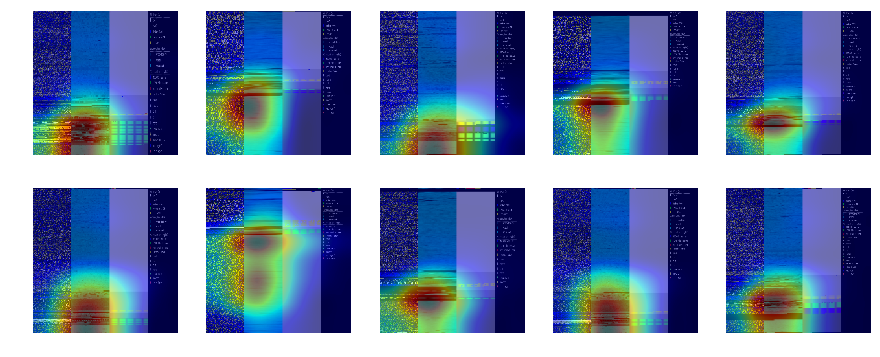

Family: autoit
Image: ['406212ca0c5bb472a69f9e0496af70ddbd54f65e768dae8fd1bece93a3439bb1.png'] - Class: ['autoit'] - Pred: 2 (autoit) - Prob: 22.15
Image: ['82112544fc9f81ccab9fbc8c8f1614b92091b87171f925a0e39b8c5694f23369.png'] - Class: ['autoit'] - Pred: 2 (autoit) - Prob: 23.54
Image: ['35e77b4f0658a438a30c1223371bfe8e1a25b6b5972a65172e97041417c5f2c0.png'] - Class: ['autoit'] - Pred: 2 (autoit) - Prob: 22.26
Image: ['41230d2356b6db8edb64c9ffdfaaa1fbea1d7fa99cae857224e2d0ad83ddea7a.png'] - Class: ['autoit'] - Pred: 2 (autoit) - Prob: 11.18
Image: ['8017b23de096c57fa5c044a36310ae40818d0a5425c58160045758dc3ede11cd.png'] - Class: ['autoit'] - Pred: 2 (autoit) - Prob: 22.50
Image: ['c9a1e926edc1987288efc5fe06fc32a5db704370eaa0a6165991ddd89211c38b.png'] - Class: ['autoit'] - Pred: 2 (autoit) - Prob: 22.25
Image: ['4800d705d59fc43fa60b3385deac3d0c08255d70a09b0b612b8504e1053c3a0d.png'] - Class: ['autoit'] - Pred: 2 (autoit) - Prob: 22.25
Image: ['cbc612061fc62f068be66a53430e0da89ba90655079c7

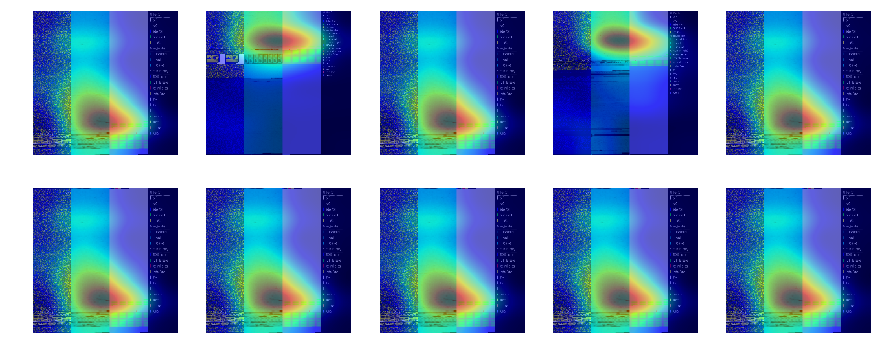

Family: daws
Image: ['df4ce379694f75e0fb308d5bbcace3a7ec998a1557e492bfaf6bf6d9e0db0c0b.png'] - Class: ['daws'] - Pred: 3 (daws) - Prob: 24.93
Image: ['e058df98f5f7892c43e07d4ed0dca139d8ebcb6f811e01635784273a8f05e68b.png'] - Class: ['daws'] - Pred: 3 (daws) - Prob: 23.74
Image: ['59dd7c4df7894d7d36d6e3756eab9cd4ab9f93206671a2a4990e7ae6262b38aa.png'] - Class: ['daws'] - Pred: 3 (daws) - Prob: 26.67
Image: ['50fe9d289d83a2707f53f43391e26c03b2e398b2ef5daba0639039a85722f964.png'] - Class: ['daws'] - Pred: 3 (daws) - Prob: 25.10
Image: ['72d89d8c5ec9b1a83e3fb703a1223e0d73c829cc69179abc682004d371698c8b.png'] - Class: ['daws'] - Pred: 3 (daws) - Prob: 10.93
Image: ['a7a33990d0b3c9a89ba9114211563d38ff7ba9f761a1a8639daf0869bcae6069.png'] - Class: ['daws'] - Pred: 3 (daws) - Prob: 24.92
Image: ['18763aa4067f7689f9ed1492e5d9b40581cc000499d371a6ecc65e6165985dc6.png'] - Class: ['daws'] - Pred: 3 (daws) - Prob: 24.77
Image: ['3054b70634e1cbd42aafc141cb39183f38320476ba263e2ce2996518c8d5e3a5.png'] - Cl

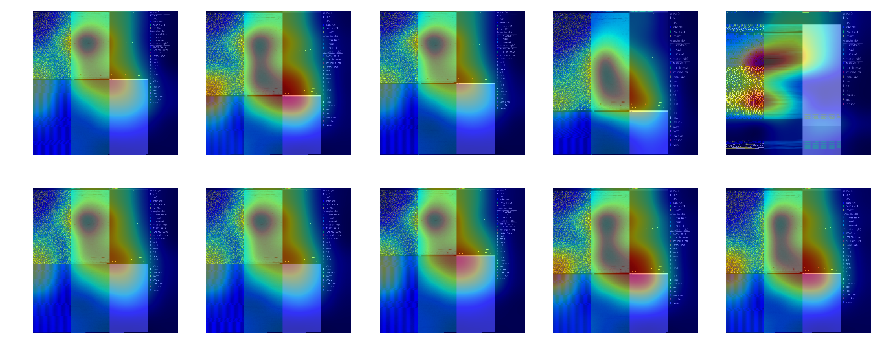

Family: delf
Image: ['94a410d932ef34ce91e4ac0e8cdeae3764224f35cfee73b01624322f8036b6ef.png'] - Class: ['delf'] - Pred: 4 (delf) - Prob: 19.32
Image: ['b223924bcbba11636c2021b80a9d98cf009b7b267eaa89cc888e02ba479e9504.png'] - Class: ['delf'] - Pred: 4 (delf) - Prob: 19.48
Image: ['9a604e13c6343d3dc99e7ae3c80aefbf1aea78f7abf2e6168dc09b31d397d74b.png'] - Class: ['delf'] - Pred: 4 (delf) - Prob: 19.10
Image: ['be289add0a7e2ff657d8a4da89ace78f4e7c4bb8a6181569518df05efa0f9db3.png'] - Class: ['delf'] - Pred: 4 (delf) - Prob: 20.76
Image: ['0ae02ce861a889e83cccac25387621772cfa2232236cf68f48494fb8093c6a3e.png'] - Class: ['delf'] - Pred: 4 (delf) - Prob: 19.37
Image: ['7294baf7d773182a849e502cb38f7047f126688097f47525adfae186441a12b5.png'] - Class: ['delf'] - Pred: 4 (delf) - Prob: 18.17
Image: ['029c790b9dc27be005aae832de64708d511c1442dbab01a1e5eff494bff03b3e.png'] - Class: ['delf'] - Pred: 4 (delf) - Prob: 20.59
Image: ['badd3d5a51c43ef6d4c50de26af65ee7571149422a3a19003726beba25134791.png'] - Cl

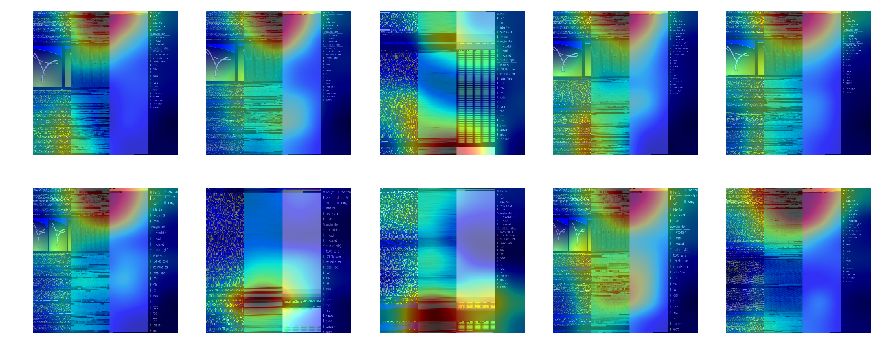

Family: gamarue
Image: ['6d6313babb2f7c8c08c1325989b61bc988a1485f29d0c14451e64a374465e0a8.png'] - Class: ['gamarue'] - Pred: 5 (gamarue) - Prob: 22.93
Image: ['17530225cf7b5d48a8298cb3dab5263306b3aeef4ed30399ef8ca1cf23905b6c.png'] - Class: ['gamarue'] - Pred: 5 (gamarue) - Prob: 26.49
Image: ['f41ceea5620f96da7ad9f21e9f989256c0e8f248d547dafc857120735d1d360b.png'] - Class: ['gamarue'] - Pred: 5 (gamarue) - Prob: 24.07
Image: ['5ce2edbffe9f629a94cfed860a83624775177d47739ae9b0addaa7b3dbb65238.png'] - Class: ['gamarue'] - Pred: 5 (gamarue) - Prob: 14.28
Image: ['7663780100daacb361fdc5c28ac65a69f8e1c9cdd193f8769adc7c0a00f7bfa7.png'] - Class: ['gamarue'] - Pred: 5 (gamarue) - Prob: 19.40
Image: ['134d8a956e52f4d255a1d583555039c5fbeeace530e159c4d96df687cf9de989.png'] - Class: ['gamarue'] - Pred: 5 (gamarue) - Prob: 17.75
Image: ['48bedc475f1aee1f07d1205f790fe36dc9d8eb811d6579fdd295d7587676204d.png'] - Class: ['gamarue'] - Pred: 5 (gamarue) - Prob: 18.40
Image: ['4ddd9bde47d1ac51f47f37865193de

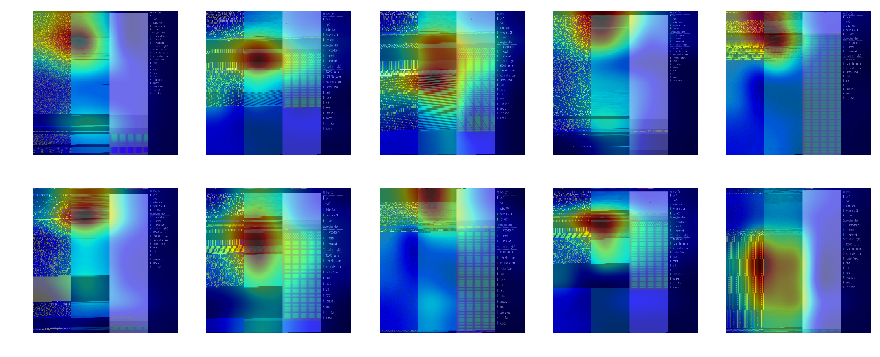

Family: ibryte
Image: ['c98f70e271b0d1bd693cda3b6e9fc057ab6f998726ccda97c88cd9460365345b.png'] - Class: ['ibryte'] - Pred: 6 (ibryte) - Prob: 28.79
Image: ['2dea992408da04052f81c952485210f97923313100ebb504082336235150410b.png'] - Class: ['ibryte'] - Pred: 6 (ibryte) - Prob: 22.79
Image: ['d162fa14760aac3af46971f854cdd9c8c2c02b2d35c1e23ce1c7a31cc17cb421.png'] - Class: ['ibryte'] - Pred: 6 (ibryte) - Prob: 20.87
Image: ['7795327da7311cfccf7fa051205c110f0bf48a012a3e4d84d13be9e904c80a12.png'] - Class: ['ibryte'] - Pred: 6 (ibryte) - Prob: 24.97
Image: ['b664fb28a92f8ae1867745f469c3ee89e4c5c78fc208d94fdddceb85b5b137f3.png'] - Class: ['ibryte'] - Pred: 6 (ibryte) - Prob: 29.16
Image: ['6be34ac79e45f3dbc51525cedc83d0067973051a9ad9b540b87fea9dabcea1cd.png'] - Class: ['ibryte'] - Pred: 6 (ibryte) - Prob: 28.32
Image: ['9bf16aec388c7c40cede8b7e2fd5895af6bcc23cf6d5d183aac3772ba45a4231.png'] - Class: ['ibryte'] - Pred: 6 (ibryte) - Prob: 25.29
Image: ['366cc0bae34c98175cd3ef938bf3f719d3b1acab5d94b

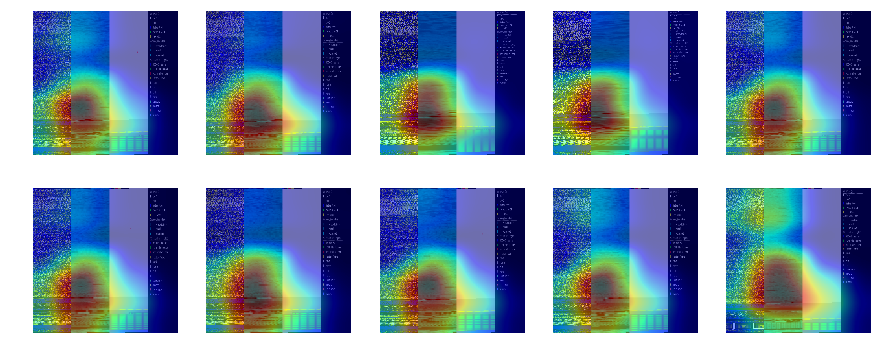

Family: loring
Image: ['4c03ea7f6b61ead1d5e6128c5d23ee0f2fa988869470ac03a71c959ebca8cada.png'] - Class: ['loring'] - Pred: 7 (loring) - Prob: 21.18
Image: ['a01ee25e8b523efdf4696c423c48e8346b3cd9a32af22401f2c2cd5a85c61faf.png'] - Class: ['loring'] - Pred: 7 (loring) - Prob: 25.05
Image: ['290439f4b1d927a24b8fe5b6dd2a2b684a6f5b093319a24122d3f6d137796364.png'] - Class: ['loring'] - Pred: 7 (loring) - Prob: 20.67
Image: ['d54987b6b9b1dab5aee2b6064a19c76ac118e891958b096fed53623363031666.png'] - Class: ['loring'] - Pred: 7 (loring) - Prob: 25.31
Image: ['61c52831d1bbba6633d4d904f56bf7827349deb5f369e89673b59aa2834950a1.png'] - Class: ['loring'] - Pred: 7 (loring) - Prob: 19.77
Image: ['c7a2cd5384b75b8771588df2fe587e058b62a0fa74e5bebc9527ceab0940648f.png'] - Class: ['loring'] - Pred: 7 (loring) - Prob: 19.84
Image: ['0ff957d01fd41e562aa1ef4288f3f54900fe6b8b2098395b3d9b526c679b30e0.png'] - Class: ['loring'] - Pred: 7 (loring) - Prob: 24.36
Image: ['d856e0b784986681b0f4b008aa4e2e2e54d3a8f8cf817

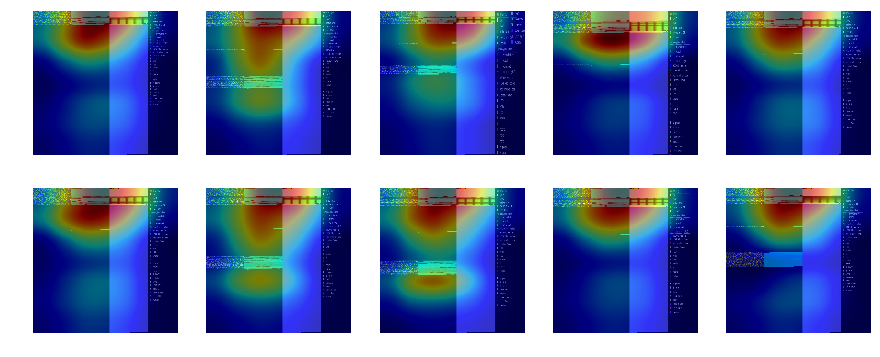

Family: mydoom
Image: ['000e9720b8c9938dc15da3402173af16509dfc777aba412e556e5e21626b8149.png'] - Class: ['mydoom'] - Pred: 8 (mydoom) - Prob: 22.41
Image: ['1950d169363540649f2b95d4ce932121549f1e4bd3e9e05afe2e437b78db662e.png'] - Class: ['mydoom'] - Pred: 8 (mydoom) - Prob: 25.81
Image: ['eb15bf4e8b480166b69799828b00143e9f0a246fba3db170844e86bdf566534e.png'] - Class: ['mydoom'] - Pred: 8 (mydoom) - Prob: 25.07
Image: ['47a3cd3b18f272f8a3fe987467ac693c74ed2c884a4787e2d23957887ee850ea.png'] - Class: ['mydoom'] - Pred: 8 (mydoom) - Prob: 22.12
Image: ['995f0b6ed9d12a5b3473afec7e3c1c8b26adfa3a15065f0a2649b938d2a46e47.png'] - Class: ['mydoom'] - Pred: 8 (mydoom) - Prob: 21.61
Image: ['cd4eef8e76a85f441e3403bb198996e96f78e6c6d08649def6faddbc9140ebcb.png'] - Class: ['mydoom'] - Pred: 8 (mydoom) - Prob: 23.03
Image: ['8234a6c53ef5edfebcc717b40ac9a6ce1be0e68b670f662d58f3e475a85eb2e3.png'] - Class: ['mydoom'] - Pred: 8 (mydoom) - Prob: 22.38
Image: ['ed5f8ce149568454c31eb8db9a415c4ccc573722c9dbc

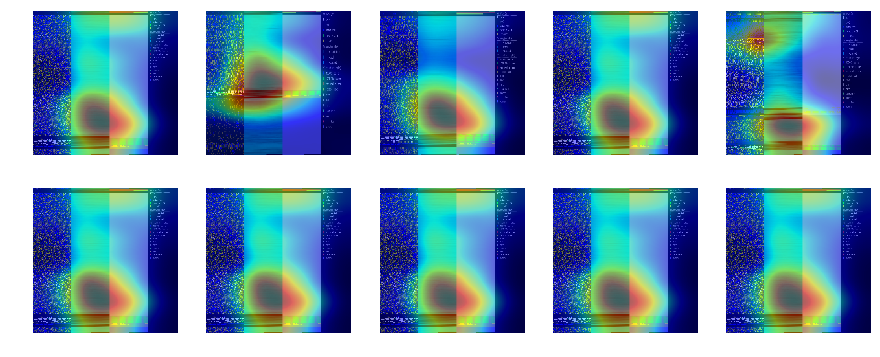

Family: qukart
Image: ['06ff5d552963d505db46498ef1e7f92af3073b1a94df57b9f1870f0247ca8d94.png'] - Class: ['qukart'] - Pred: 9 (qukart) - Prob: 23.90
Image: ['52a4d98d38ba5d63394b0690b81ba83498129af48ffcf9f416df698a73b428ec.png'] - Class: ['qukart'] - Pred: 9 (qukart) - Prob: 23.30
Image: ['2a1b7a5afa6027eac10a368c5a555d7db156022af6dabf1ec9c272325e20ef67.png'] - Class: ['qukart'] - Pred: 9 (qukart) - Prob: 28.08
Image: ['8e9127c74a0cc622d65be8b03a50c33d2d6375373995c12432891aa7f50dd171.png'] - Class: ['qukart'] - Pred: 9 (qukart) - Prob: 23.69
Image: ['9bbed3580cb4e15139f1ef16197d3d94217148802bcb8c53d97cdf1be507d70a.png'] - Class: ['qukart'] - Pred: 9 (qukart) - Prob: 24.29
Image: ['2672e4ff7886d66f34b21ebd944f6e145155b56483c12bdb4c570568e98bff8e.png'] - Class: ['qukart'] - Pred: 9 (qukart) - Prob: 25.21
Image: ['003396011e8f6b343a4f5a3f2a31c35e9f822ed4d1df86f72063322499936982.png'] - Class: ['qukart'] - Pred: 9 (qukart) - Prob: 19.67
Image: ['318ecd66f87932f9bcb1f1bbd1bedb4a903cb5c7faadb

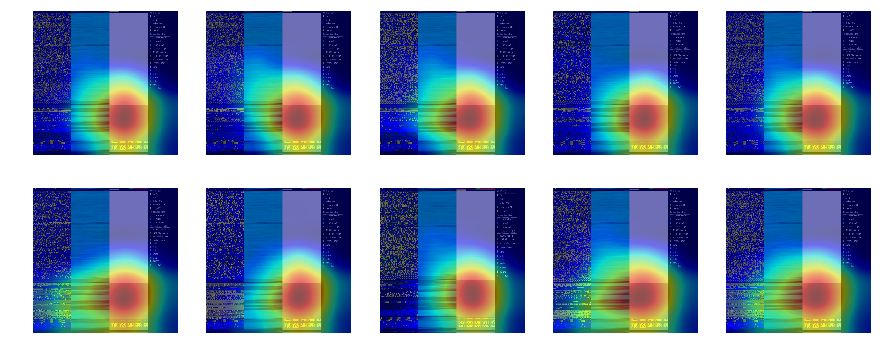

Family: ramnit
Image: ['e508a8c5c025ada539f00aa1eb6eae015611c4ae16677b7d26db8953c295eac8.png'] - Class: ['ramnit'] - Pred: 10 (ramnit) - Prob: 12.89
Image: ['a1ea151f9ef0d7515be279d214bff1ec583459293b5816322296b885c8d1bada.png'] - Class: ['ramnit'] - Pred: 10 (ramnit) - Prob: 6.57
Image: ['d905fc0c7a4041d9acbb80701b2a273a6b0a518968b2af27803c7185e864274e.png'] - Class: ['ramnit'] - Pred: 10 (ramnit) - Prob: 16.52
Image: ['56e7ce390d2a02ea55ece1726cc4398f4d97a72b2c063fb017434752922e68e3.png'] - Class: ['ramnit'] - Pred: 10 (ramnit) - Prob: 17.36
Image: ['2a9ca008e37a03df5ff2040b6a67c812ae57b10541b35f3f878b2f63b4ee7717.png'] - Class: ['ramnit'] - Pred: 10 (ramnit) - Prob: 16.62
Image: ['9193b1dc8f59c5038a7dbdaeb4f5318e88df2b35cad29abc75426ad68c292439.png'] - Class: ['ramnit'] - Pred: 10 (ramnit) - Prob: 18.74
Image: ['5c2c9c2254b3b5cac8c349bb398089fa1282dfe90484412345cc92a6ff6eeb7c.png'] - Class: ['ramnit'] - Pred: 10 (ramnit) - Prob: 17.17
Image: ['f0baede2a382c0d72279c18e085e2146a4c51ae

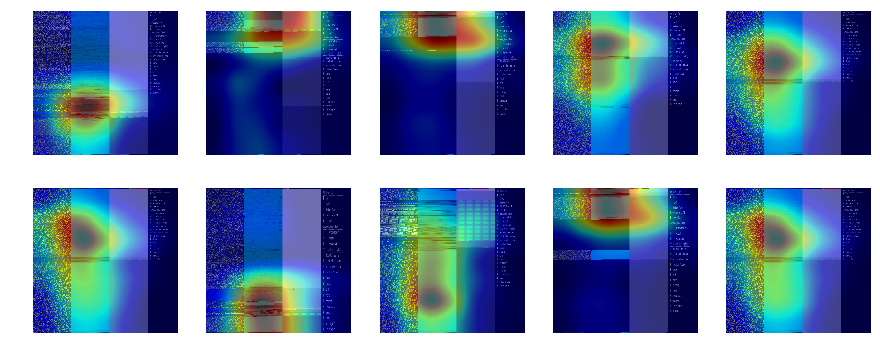

Family: sality
Image: ['b6532ed5a65a92926ac5f90545b3a736b1f2d459fe87aee9b332c3aff41988bc.png'] - Class: ['sality'] - Pred: 11 (sality) - Prob: 15.96
Image: ['99f3b69fae6c38e122fc1aaefaf959f6e1dca91bd99a8b3e63be55ab90d89582.png'] - Class: ['sality'] - Pred: 11 (sality) - Prob: 21.54
Image: ['583ad4bc7021a639e375339af103118538320db5dcbc4b27502e56017f0f2153.png'] - Class: ['sality'] - Pred: 11 (sality) - Prob: 21.65
Image: ['967ed08bad130495a4a0fbf4fcae6d3f0e1770a477426d38d32b70ac18619ee9.png'] - Class: ['sality'] - Pred: 11 (sality) - Prob: 23.87
Image: ['8b6de5813397652ee014ddd800a3055de66015439737f5b25679c596e3587de9.png'] - Class: ['sality'] - Pred: 11 (sality) - Prob: 26.10
Image: ['5e242da449f0a0e76aa74c2cf2e0b5728c1618e01770bb1ae9dc8487b85c6cf6.png'] - Class: ['sality'] - Pred: 11 (sality) - Prob: 15.51
Image: ['0308d50ab8b4e630c9bedbb4093bd16340c583b5ae045d5950c623bb84b5857b.png'] - Class: ['sality'] - Pred: 11 (sality) - Prob: 17.26
Image: ['1dba92ee5ab66dbabae828c653c5e5becc582e

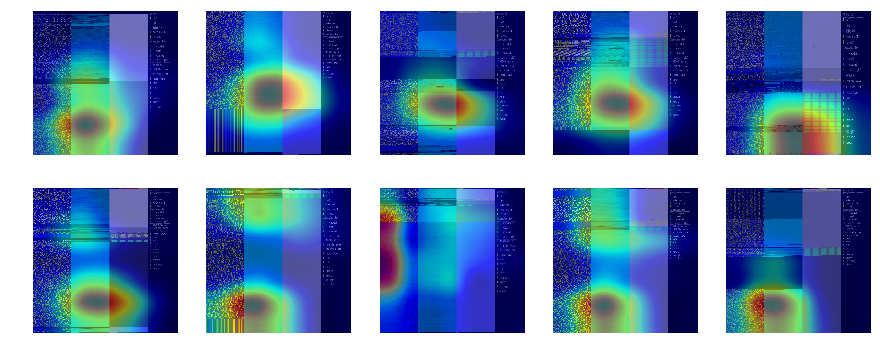

Family: simbot
Image: ['237f73a2ad184a9f1408355569da6f9c568d855fc4545be26da662943fee4788.png'] - Class: ['simbot'] - Pred: 12 (simbot) - Prob: 17.50
Image: ['ea3586f04eccb834d9207b8668e6912ec3ffdeef2452f1060878815a533c6269.png'] - Class: ['simbot'] - Pred: 12 (simbot) - Prob: 23.67
Image: ['1193f5ab5fcfae525cf1bc10795b9c3a71f2cbffa0e6103926a047d014257dda.png'] - Class: ['simbot'] - Pred: 12 (simbot) - Prob: 21.52
Image: ['a2291a80f0073f414a6a4553d213674ca685ecbb1d108f58e67910b673a63656.png'] - Class: ['simbot'] - Pred: 12 (simbot) - Prob: 22.23
Image: ['87689fdcfcee9dc6e2c9190de02519b660f8db9ae259f1b1e2af81408ed92811.png'] - Class: ['simbot'] - Pred: 12 (simbot) - Prob: 22.96
Image: ['2f35a7ce2e4f08fb0cd54e51f2b652315b1870108772d14759c46be8184091d7.png'] - Class: ['simbot'] - Pred: 12 (simbot) - Prob: 21.62
Image: ['dc3c2cac46420220d287b41d85ed215a7b2bc6d996240ea630e5ee2685f4dfee.png'] - Class: ['simbot'] - Pred: 12 (simbot) - Prob: 22.38
Image: ['e873b6f5999a46fe08a06051540dd93617cede

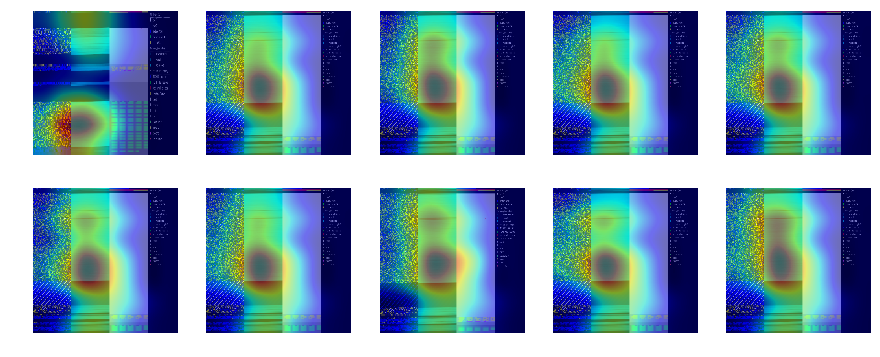

Family: softpulse
Image: ['60ae18e0e204fb328f76654563362a884dbec3bd79f0689165378ab462abac1f.png'] - Class: ['softpulse'] - Pred: 13 (softpulse) - Prob: 23.01
Image: ['9f20e5448cca681630d4b6c28b702631b3395294b877a7b797c0d7b69c73dbfe.png'] - Class: ['softpulse'] - Pred: 13 (softpulse) - Prob: 22.99
Image: ['571c8cf127131f885aaf5fb2418c8d8172e4d36e9c51026407ad58b78101998f.png'] - Class: ['softpulse'] - Pred: 13 (softpulse) - Prob: 20.95
Image: ['82179e72ca565f0d5c4f172c807212fde309849442900dfc9cd8d90ab10f1f58.png'] - Class: ['softpulse'] - Pred: 13 (softpulse) - Prob: 22.60
Image: ['39b65ef0b08fdcc5e6ab1a6db7969d24dadecde83f31298790a981b17d73aaf9.png'] - Class: ['softpulse'] - Pred: 13 (softpulse) - Prob: 23.01
Image: ['adfb983bd14d6f630122f033deeadba72342093571a108696435a7c2d5046c0c.png'] - Class: ['softpulse'] - Pred: 13 (softpulse) - Prob: 23.01
Image: ['6eb9d446718258b10edc0aceec901cc641b64807b3a76e590ec1ed946b282443.png'] - Class: ['softpulse'] - Pred: 13 (softpulse) - Prob: 23.01
Im

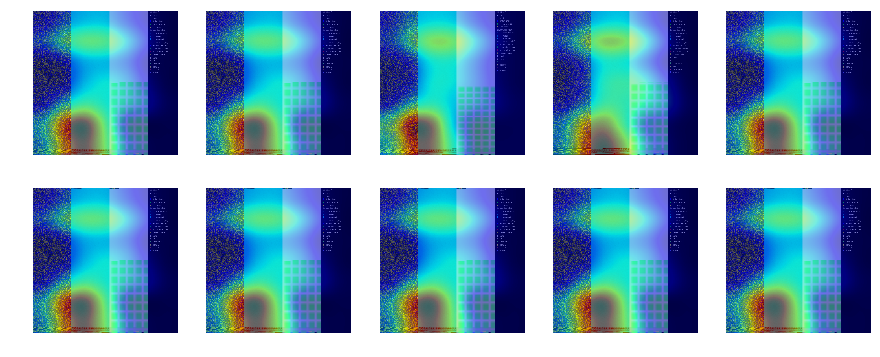

Family: viking
Image: ['f40c9191ee8fec6b6513d080b8f3cb3b277e946b7ec6fb3195cbfd5250d939e8.png'] - Class: ['viking'] - Pred: 14 (viking) - Prob: 20.09
Image: ['ff90ccfa3261d2e8fff6ae736ea379a19e496b2aa95895a41448e24963a278a0.png'] - Class: ['viking'] - Pred: 14 (viking) - Prob: 25.82
Image: ['ce275e85096c8c398c88b201acd901808e06d72c3eca50ebc3cb27bef159e442.png'] - Class: ['viking'] - Pred: 14 (viking) - Prob: 23.81
Image: ['94a05587a1faf3bf877d7514f870e9dad33b0903bfdecbac1b4f901ec681dcd8.png'] - Class: ['viking'] - Pred: 14 (viking) - Prob: 16.01
Image: ['668cf7e4b31546079f9ff542fae417e8aab91b92b49d8c1f9e39b9b3de1843db.png'] - Class: ['viking'] - Pred: 14 (viking) - Prob: 27.04
Image: ['a407beecd7cb79c2dcf121e06abbbd449c0500f58ff184c8c21672e87bd47b22.png'] - Class: ['viking'] - Pred: 14 (viking) - Prob: 22.51
Image: ['1a447c4241f1003fa1d2039fdd21d2924591b630db4e97aa462060e3c01a95dd.png'] - Class: ['viking'] - Pred: 14 (viking) - Prob: 32.18
Image: ['cc9e27814d95bfe38c852aee90b3ea0ea0f59b

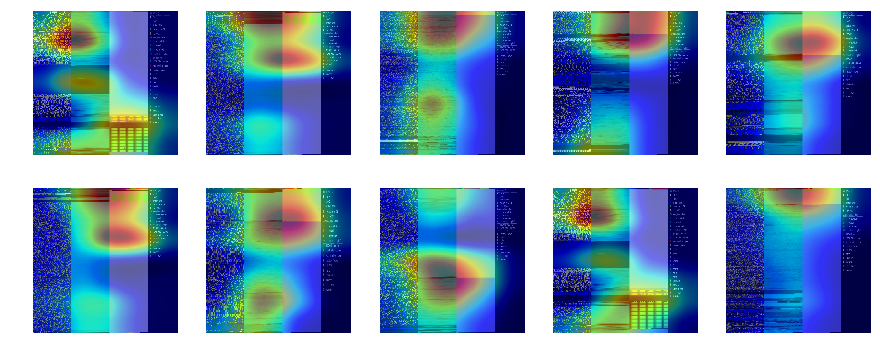

Family: virlock
Image: ['b9c1c7ae1a4aeac62c8115c91254517a7ea81fec7dde3a17ee86c21ba1be62db.png'] - Class: ['virlock'] - Pred: 15 (virlock) - Prob: 34.35
Image: ['a141867258d903b537d1b286ac42d7c2fe13d9780f2d2fb14dd04c91af599230.png'] - Class: ['virlock'] - Pred: 15 (virlock) - Prob: 38.34
Image: ['158b883b72854060b6e9236f5a82c3a001ba42c46e92295648c47d39bcb5a755.png'] - Class: ['virlock'] - Pred: 15 (virlock) - Prob: 32.40
Image: ['19b428a5f371f406d17d5353e70c1dd1519e88867bbead6d133468ca24715984.png'] - Class: ['virlock'] - Pred: 15 (virlock) - Prob: 34.36
Image: ['a4779c349db87d4d150a6362ce9c3c743dc71bf31da0b953faf19431a977d9a2.png'] - Class: ['virlock'] - Pred: 15 (virlock) - Prob: 20.25
Image: ['f23f1b5c695cb7daf7e7d16f497107e44057365de6183d5741b87d03843ae33e.png'] - Class: ['virlock'] - Pred: 15 (virlock) - Prob: 33.72
Image: ['8a8d5473f73efc4f0ac286655ce6f7d407922cffc9909befad79e51b4f1ea768.png'] - Class: ['virlock'] - Pred: 15 (virlock) - Prob: 22.88
Image: ['214edfddd51d776da4251f0

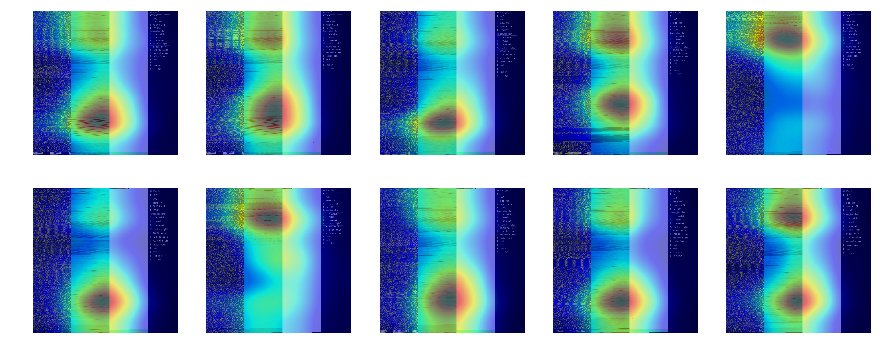

Family: vobfus
Image: ['f81af1b04a9f6281d939d3a063b6e9ff332fbee5f7bbea8be6a46e262d4a7f90.png'] - Class: ['vobfus'] - Pred: 16 (vobfus) - Prob: 12.49
Image: ['a0cad193fef6c7b1d023f11b090b3e31b3907701fd4cfd5bb47e4008df2beaf0.png'] - Class: ['vobfus'] - Pred: 16 (vobfus) - Prob: 6.67
Image: ['42dd95cab114338c8bb70ba43d8fb4ad430ad00cd8f9466c932842b79fcf03c0.png'] - Class: ['vobfus'] - Pred: 16 (vobfus) - Prob: 15.11
Image: ['207b25fc88953e80b16fceb6b5bd286296172eae4da8b7feee2a2843d4ac8f4b.png'] - Class: ['vobfus'] - Pred: 16 (vobfus) - Prob: 17.91
Image: ['017755f6d52e60efdd15958804c1aa52f45af8c433dcfe97c419d4e0a4a3d081.png'] - Class: ['vobfus'] - Pred: 16 (vobfus) - Prob: 15.58
Image: ['6c46860f67905f977eb59046091d0dcdc72bf3287c4ed0f19804bfc03a24e6c2.png'] - Class: ['vobfus'] - Pred: 16 (vobfus) - Prob: 16.98
Image: ['3fbd0a5e503593896664cfc71148f57df2770cdff489be6e52c0ebd3620b0d96.png'] - Class: ['vobfus'] - Pred: 16 (vobfus) - Prob: 10.28
Image: ['0b3521965157a148733cac03ed7d8223d2d3568

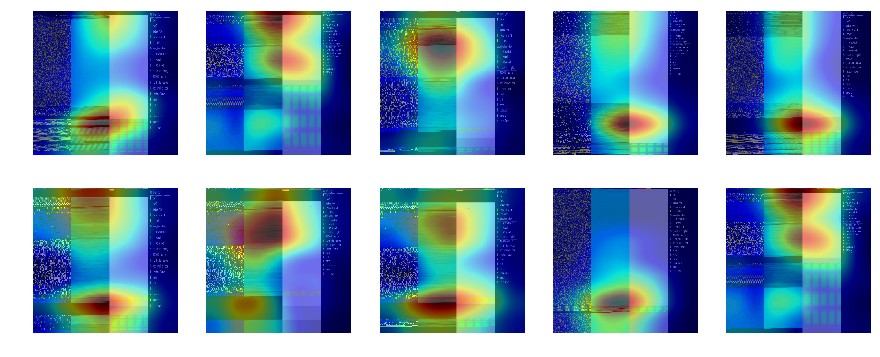

Family: wapomi
Image: ['fd477ee611516bc9bb4cda4c25f5e9a2bd5469d95b399dec202e3d4d9bcf4d6a.png'] - Class: ['wapomi'] - Pred: 17 (wapomi) - Prob: 31.58
Image: ['db603b319c3d4a03aa5f95a8dd7aafa8781dacf876d95ca7f3afb702829bd47f.png'] - Class: ['wapomi'] - Pred: 17 (wapomi) - Prob: 41.94
Image: ['e75929dfab1a4c9165e8af2d8e13081d30e61012e284c0130b75b04390ec033b.png'] - Class: ['wapomi'] - Pred: 17 (wapomi) - Prob: 29.64
Image: ['96a2d7d4b9e43243c5004ce82b9574f486a109cb20e3340bcc1413e0f65df93b.png'] - Class: ['wapomi'] - Pred: 17 (wapomi) - Prob: 38.25
Image: ['32e43809d5857b87ed23b6be308f60d31d4f90fd3aa15e160265676fc9051d6d.png'] - Class: ['wapomi'] - Pred: 17 (wapomi) - Prob: 26.24
Image: ['ee473150824333aef6d1a531831c3e9cf1e79a796fde022c0fe1b0385b2aa456.png'] - Class: ['wapomi'] - Pred: 17 (wapomi) - Prob: 20.17
Image: ['b325492525e14e7dd96af6a505f20b0b0cb382256a915c580146b2cedc0d7054.png'] - Class: ['wapomi'] - Pred: 17 (wapomi) - Prob: 20.00
Image: ['af0b63b9151cb2d1fccd3ee641e0fd0ef802f1

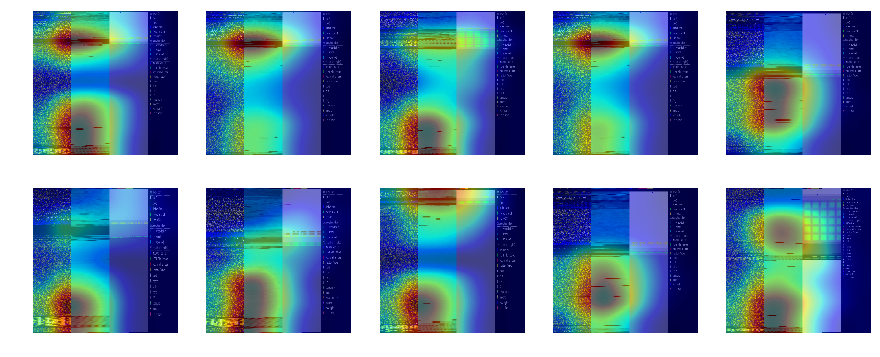

Family: zbot
Image: ['7c119b783e987842545c13e6c33bbf4a4057ea45d46370112e1bed786f9e2186.png'] - Class: ['zbot'] - Pred: 18 (zbot) - Prob: 24.31
Image: ['6b49b66d9480cb8def3117496722c5f28d739784202b808ef39445fb9b8534a5.png'] - Class: ['zbot'] - Pred: 18 (zbot) - Prob: 17.98
Image: ['d1f7c59d58a29fd5c74cd331212b036e963554c20d2e0178e2b83a0824b0958c.png'] - Class: ['zbot'] - Pred: 18 (zbot) - Prob: 21.19
Image: ['19501f93734bfae13cb40a4acbc26dd88aa283c17a5540da74afbceb7c605b9d.png'] - Class: ['zbot'] - Pred: 18 (zbot) - Prob: 15.13
Image: ['11c7cc6f408225c1d63f98d980e84a9e7a3e5915fbe1232765bd7ff410409e98.png'] - Class: ['zbot'] - Pred: 18 (zbot) - Prob: 14.52
Image: ['d70613005ba9e8299017ad227abf94cc527d426979d255a0c3392fe68121c505.png'] - Class: ['zbot'] - Pred: 18 (zbot) - Prob: 19.34
Image: ['439f331f1193005bab42f18faed822b2b9345762a7a81ca501063d6e655ccae2.png'] - Class: ['zbot'] - Pred: 18 (zbot) - Prob: 15.61
Image: ['e5c79773461e841e026a16307266670509189b3620e8195a8e7be159dc163d16.png

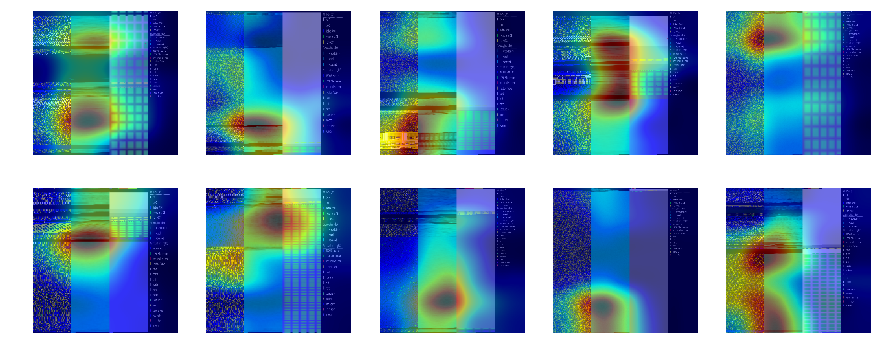

Family: zegost
Image: ['6615446412a6d4005befa114f0718015d973ff03a1e7f09096edd5e63adbd299.png'] - Class: ['zegost'] - Pred: 19 (zegost) - Prob: 16.74
Image: ['a6202b74e469e686bcfda3fbdfaf3551ffea08431ebf5974fa95232e1ce5c222.png'] - Class: ['zegost'] - Pred: 19 (zegost) - Prob: 21.47
Image: ['c0122ac83d646f02b884738bd7e759ae555a6552f595ebcf9c8ff7972dfe50ba.png'] - Class: ['zegost'] - Pred: 19 (zegost) - Prob: 21.19
Image: ['d7adfe8806b2ae48b74796a15fe28471ce4a5bcb7e534214f6fd140f23e926d8.png'] - Class: ['zegost'] - Pred: 19 (zegost) - Prob: 19.67
Image: ['5fde7fb53775bf9bc3a69b2e8e0e7eebe90f613c10491143ab898439a37b0c02.png'] - Class: ['zegost'] - Pred: 19 (zegost) - Prob: 21.67
Image: ['6eaadd1d83ea4f8397e04963de6830c24d291a0ce08bd690db29d252a074aaff.png'] - Class: ['zegost'] - Pred: 19 (zegost) - Prob: 27.18
Image: ['ee9fa821d870dfe1d19fe7e747ae65f1ec4e35b884158f0aa215f6db43027c67.png'] - Class: ['zegost'] - Pred: 19 (zegost) - Prob: 27.19
Image: ['7271f0c69ee48538dbb06ea69ef85c3b473ac7

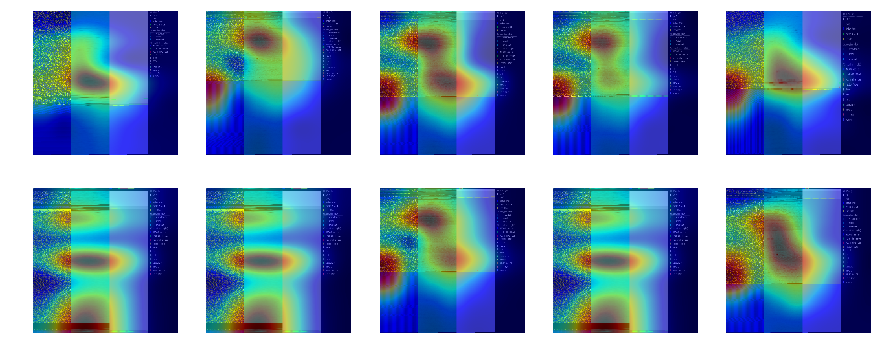

In [8]:
samplesbyfamily = 10
samplesbyrow = 5
for fam in list_fams:
    print("Family: %s" %(fam))
    fam_samples = [name for name in list_paths if fam in name]
    image_paths = random.sample(fam_samples, samplesbyfamily)
    
    #fig = plt.figure(figsize=(16, 8))
    f, ax = plt.subplots(samplesbyfamily//samplesbyrow, samplesbyrow)
    f.set_size_inches(3*samplesbyrow, 3*(samplesbyfamily//samplesbyrow))
    ind = 0
    
    for path in image_paths:        
        img = io.imread(path)
        #img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
        img = cv2.resize(img, (224, 224))
        img = image.img_to_array(img)
        
        x = image.load_img(path, target_size=(224, 224))
        x = image.img_to_array(x)
        x = preprocess_input(x)
        pred_class = np.argmax(model.predict(np.array([x])))
        pred_proba = np.amax(model.predict(np.array([x])))
        print("Image: %s - Class: %s - Pred: %d (%s) - Prob: %.2f" %(path.split('/')[-1:],path.split('/')[-2:-1],pred_class,list_fams[pred_class],pred_proba))
        
        heatmapguided = visualize_cam(model, layer_idx, filter_indices=[pred_class], seed_input=x, penultimate_layer_idx=penultimate_layer_idx)        
        
        ax[ind//samplesbyrow,ind%samplesbyrow].axis('off')
        ax[ind//samplesbyrow,ind%samplesbyrow].imshow(overlay(heatmapguided, img))
        ind = ind + 1
        
    plt.show()